In [85]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score
from sklearn.model_selection import ShuffleSplit 
from sklearn import svm
from pandas import ExcelWriter
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot as plt
from scipy import stats
import seaborn as sbn
import timeit
import numpy as np
import re
import random


def xy_sets(line):
    X=None
    y=None
    indexes = map(int, re.findall('\d+', line))
    aux = False
    for i in indexes:
        if aux is False:
            X = scaled[i, :]
            y = target[i]
            aux = True
            continue
        X = np.vstack((X, scaled[i, :]))
        y = np.hstack((y, target[i]))
        
    return X, y, indexes


In [86]:
# parametrizacao geral
poly_models = np.linspace(0.001, 0.02, 20)
dataset_name = ['57', '54']
tech = ['svm', 'knn', 'ann']

# parametrizacao ann
n_hidden = [2, 3]
alpha = [0.001, 0.01, 0.1, 1]
activation = ['identity', 'logistic', 'tanh']

# parametrizacao knn
kneighbors = np.arange(1, 11)

# parametrizacao svm
kers = ['linear', 'poly', 'rbf']

# fst_part = read_csv('57_'+str(0.001)+'.csv', header=0, index_col=(0,1))
# scd_part = read_csv('54_'+str(0.001)+'.csv', header=0, index_col=(0,1))
# parts = [fst_part, scd_part]
# dataset = concat(parts)
# dataset
poly_models

array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
       0.019, 0.02 ])

In [87]:
start = timeit.default_timer()

svm_accs = []
knn_accs = []
ann_accs = []

svm_best_para = []
knn_best_para = []
ann_best_para = []

svm_folds_accs = [np.array([]), [], []]
knn_folds_accs = [np.array([]), [], []]
ann_folds_accs = [np.array([]), [], []]

i = 0
for m in poly_models:
    m = round(m, 4)
    fst_part = read_csv('57_'+str(m)+'.csv', header=0, index_col=(0,1))
    scd_part = read_csv('54_'+str(m)+'.csv', header=0, index_col=(0,1))
    parts = [fst_part, scd_part]
    dataset = concat(parts)
    for t in tech:
        if t == 'svm':
            max_acc = 0
            max_folds_acc = np.zeros(20)
            best_para = None
            aux_svm = []
            for ker in kers:
                # pega apenas os valores contidos no dataset
                values = dataset.values
                
                # divide o dataset em data(input) e target(output)
                data = values[:, 1:] 
                target = values[:, 0]
                
                # normaliza as features
                scaled = normalize(data[:, :3], norm='max', axis=0)
                scaled = np.concatenate((scaled, data[:, :4]), axis = 1)
                
                scores = np.zeros(20)
                col = np.array([])
                cont = 0
                sns = 0  # true negatives rate
                spf = 0  # true positives rate
                y_test_full = np.array([])
                y_cont_full = np.array([])
                
                file = open('combined_kf.txt', 'r')
                while cont < 20:

                    train_line = file.readline()
                    test_line = file.readline()

                    X_train, y_train, train_indexes = xy_sets(train_line)
                    X_test, y_test, test_indexes = xy_sets(test_line)
                    
                    #create the SVM
                    clf = svm.SVC(gamma='auto', kernel=ker)
                    clf.fit(X_train, y_train)
                    
                    y_pred = clf.predict(X_test)
                    scores[cont] = accuracy_score(y_test, y_pred)
                    
                    y_test_full = np.hstack((y_test_full, y_test))
                    y_cont_full = np.hstack((y_cont_full, y_pred))
                
                    cont += 1
                
                file.close()
                
                conf_m = confusion_matrix(y_test_full, y_cont_full)
                
                acc = accuracy_score(y_test_full, y_cont_full)
                spf = conf_m[0, 0]/(conf_m[0, 0]+conf_m[1, 0])
                sns = conf_m[1, 1]/(conf_m[1, 1]+conf_m[0, 1])
                
                if acc > max_acc:
                    max_acc = acc
                    max_folds_acc = scores
                    best_para = (ker)
            
            svm_folds_accs[0] = np.hstack((svm_folds_accs[0], max_folds_acc))
            pm = [m] * 20
            svm_folds_accs[1] = svm_folds_accs[1] + pm
            tec = ['svm'] * 20
            svm_folds_accs[2] = svm_folds_accs[2] + tec
            
            svm_best_para.append(best_para)
            svm_accs.append(max_acc)
        elif t == 'knn':
            max_acc = 0
            max_folds_acc = np.zeros(20)
            best_para = None
            for k in kneighbors:
                # pega apenas os valores contidos no dataset
                values = dataset.values

                # divide o dataset em data(input) e target(output)
                data = values[:, 1:] 
                target = values[:, 0]

                # normaliza as features
                scaled = normalize(data[:, :3], norm='max', axis=0)
                scaled = np.concatenate((scaled, data[:, :4]), axis = 1)

                scores = np.zeros(20)
                col = np.array([])
                cont = 0
                sns = 0  # true negatives rate
                spf = 0  # true positives rate
                y_test_full = np.array([])
                y_cont_full = np.array([])

                file = open('combined_kf.txt', 'r')
                while cont < 20:

                    train_line = file.readline()
                    test_line = file.readline()

                    X_train, y_train, train_indexes = xy_sets(train_line)
                    X_test, y_test, test_indexes = xy_sets(test_line)

                    classifier = KNeighborsClassifier(n_neighbors=k)  # classifier 
                    classifier.fit(X_train, y_train)
                    scores[cont] = classifier.score(X_test, y_test)
                    y_pred = classifier.predict(X_test)

                    y_test_full = np.hstack((y_test_full, y_test))
                    y_cont_full = np.hstack((y_cont_full, y_pred))

                    cont += 1

                file.close()
                
                conf_m = confusion_matrix(y_test_full, y_cont_full)
                
                acc = accuracy_score(y_test_full, y_cont_full)
                spf = conf_m[0, 0]/(conf_m[0, 0]+conf_m[1, 0])
                sns = conf_m[1, 1]/(conf_m[1, 1]+conf_m[0, 1])
                
                if acc > max_acc:
                    max_acc = acc
                    max_folds_acc = scores
                    best_para = (k)
            
            knn_folds_accs[0] = np.hstack((knn_folds_accs[0], max_folds_acc))
            pm = [m] * 20
            knn_folds_accs[1] = knn_folds_accs[1] + pm
            tec = [t] * 20
            knn_folds_accs[2] = knn_folds_accs[2] + tec
            
            knn_best_para.append(best_para)
            knn_accs.append(max_acc)

        elif t == 'ann':
            max_acc = 0
            max_folds_acc = np.zeros(20)
            best_para = None
            for n in n_hidden:
                for a in alpha:
                    for f in activation:
                        # pega apenas os valores contidos no dataset
                        values = dataset.values

                        # split data set into data(input) and target(output)
                        data = values[:, 1:] 
                        target = values[:, 0]

                        # normalize features
                        scaled = normalize(data[:, :3], norm='max', axis=0)
                        scaled = np.concatenate((scaled, data[:, :4]), axis = 1)

                        scores = np.zeros(20)
                        col = np.array([])
                        cont = 0
                        sensitivity = 0  # true positives rate
                        specificity = 0  # true negatives rate
                        y_test_full = np.array([])
                        y_cont_full = np.array([])

                        file = open('combined_kf.txt', 'r')
                        while cont < 20:

                            train_line = file.readline()
                            test_line = file.readline()

                            X_train, y_train, train_indexes = xy_sets(train_line)
                            X_test, y_test, test_indexes = xy_sets(test_line)

                            classifier = MLPClassifier(hidden_layer_sizes=(n,), activation=f, solver='lbfgs', 
                                                        alpha=a, random_state=11, verbose=False)  # classifier 
                            classifier.fit(X_train, y_train)
                            scores[cont] = classifier.score(X_test, y_test)
                            y_pred = classifier.predict(X_test)

                            y_test_full = np.hstack((y_test_full, y_test))
                            y_cont_full = np.hstack((y_cont_full, y_pred))

                            cont += 1

                        file.close()

                        conf_m = confusion_matrix(y_test_full, y_cont_full)

                        acc = accuracy_score(y_test_full, y_cont_full)
                        spf = conf_m[0, 0]/(conf_m[0, 0]+conf_m[1, 0])
                        sns = conf_m[1, 1]/(conf_m[1, 1]+conf_m[0, 1])

                        if acc > max_acc:
                            max_acc = acc
                            max_folds_acc = scores   
                            best_para = (n, a, f)  # multiplier and best parameters


            ann_folds_accs[0] = np.hstack((ann_folds_accs[0], max_folds_acc))
            pm = [m] * 20
            ann_folds_accs[1] = ann_folds_accs[1] + pm
            tec = [t] * 20
            ann_folds_accs[2] = ann_folds_accs[2] + tec

            ann_best_para.append(best_para)
            ann_accs.append(max_acc)
        else:
            print('qq ta conteceno? nem deveria chegar aqui')
        i += 1
stop = timeit.default_timer()
print('Time: ', stop - start) 

Time:  152.3157193980005


In [88]:
print(svm_best_para)
print()
print()
print(knn_best_para)
print()
print()
print(ann_best_para)

['linear', 'rbf', 'rbf', 'rbf', 'linear', 'linear', 'linear', 'rbf', 'linear', 'rbf', 'rbf', 'linear', 'rbf', 'linear', 'rbf', 'linear', 'rbf', 'linear', 'rbf', 'linear']


[9, 6, 5, 3, 8, 5, 5, 5, 3, 3, 3, 5, 5, 7, 4, 4, 7, 7, 5, 7]


[(2, 0.1, 'identity'), (2, 0.001, 'logistic'), (2, 0.001, 'tanh'), (2, 0.01, 'logistic'), (2, 0.001, 'logistic'), (2, 0.01, 'logistic'), (3, 0.1, 'logistic'), (3, 0.01, 'logistic'), (2, 0.001, 'logistic'), (2, 0.001, 'logistic'), (2, 0.01, 'logistic'), (2, 0.01, 'tanh'), (2, 0.001, 'logistic'), (2, 0.01, 'logistic'), (2, 0.001, 'logistic'), (3, 0.01, 'logistic'), (2, 0.01, 'tanh'), (2, 0.01, 'tanh'), (2, 0.1, 'logistic'), (2, 0.1, 'logistic')]


In [175]:
start = timeit.default_timer()

svm_avg_accs = []

svm_folds_accs = [np.array([]), [], []]

svm_accs_poly = np.zeros((poly_models.shape[0], 100))
svm_auc_poly = np.zeros((poly_models.shape[0], 100))

for i in range(poly_models.shape[0]):  # for each epsilon 
    m = round(poly_models[i], 4)
    fst_part = read_csv('57_'+str(m)+'.csv', header=0, index_col=(0,1))
    scd_part = read_csv('54_'+str(m)+'.csv', header=0, index_col=(0,1))
    parts = [fst_part, scd_part]
    dataset = concat(parts)
    # test holdout 100 for the best set of parameters 
        
    ker = svm_best_para[i]  # best set of parameters

    values = dataset.values  # only gets the values within the dataset

    # divide the dataset into data(input) and target(output)
    data = values[:, 1:] 
    target = values[:, 0]

    scaled = normalize(data[:, :3], norm='max', axis=0)  # normalization
    scaled = np.concatenate((scaled, data[:, :4]), axis = 1)

    scores = np.zeros(20)
    col = np.array([])
    cont = 0
    acc = 0
    sns = 0  # true negatives rate
    spf = 0  # true positives rate

    y_test_full = np.array([])
    y_pred_full = np.array([])

    clf = svm.SVC(gamma='auto', kernel=ker) # create the SVM

    ss = ShuffleSplit(n_splits=100, test_size=11, random_state=42)
    
    j = 0
    
    for train_index, test_index in ss.split(data):
#             print("%s %s" % (train_index, test_index))

        X_train = data[train_index, :]
        y_train = target[train_index]

        X_test = data[test_index, :]
        y_test = target[test_index]

        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        scores[cont] = accuracy_score(y_test, y_pred)

        y_test_full = np.hstack((y_test_full, y_test))
        y_pred_full = np.hstack((y_pred_full, y_pred))
    
        conf_m = confusion_matrix(y_test, y_pred)
        
        acc = accuracy_score(y_test, y_pred)
        spf = conf_m[0, 0]/(conf_m[0, 0]+conf_m[0, 1])
        spf = conf_m[1, 1]/(conf_m[1, 1]+conf_m[1, 0])
        
        svm_accs_poly[i, j] = acc
        svm_auc_poly[i, j] = (sns + spf)/2
        
        svm_folds_accs[0] = np.hstack((svm_folds_accs[0], acc))
        pm = [m]
        svm_folds_accs[1] = svm_folds_accs[1] + pm
        tec = ['svm']
        svm_folds_accs[2] = svm_folds_accs[2] + tec
        
        j += 1

    conf_m_full = confusion_matrix(y_test_full, y_pred_full)    
    avg_acc = accuracy_score(y_test_full, y_pred_full)
    svm_avg_accs.append(avg_acc)
    
stop = timeit.default_timer()
print('Time: ', stop - start) 
svm_accs_poly

Time:  2.908602128001803


array([[0.81818182, 0.81818182, 0.81818182, ..., 0.90909091, 0.90909091,
        0.81818182],
       [0.72727273, 0.81818182, 0.81818182, ..., 0.90909091, 0.81818182,
        0.81818182],
       [0.90909091, 0.81818182, 0.81818182, ..., 0.90909091, 0.81818182,
        0.81818182],
       ...,
       [0.81818182, 0.81818182, 0.81818182, ..., 0.90909091, 0.90909091,
        0.72727273],
       [0.81818182, 0.81818182, 0.81818182, ..., 0.90909091, 0.90909091,
        0.72727273],
       [0.81818182, 0.81818182, 0.81818182, ..., 0.90909091, 0.90909091,
        0.72727273]])

In [177]:
start = timeit.default_timer()

knn_avg_accs = []
knn_folds_accs = [np.array([]), [], []]

knn_accs_poly = np.zeros((poly_models.shape[0], 100))
knn_auc_poly = np.zeros((poly_models.shape[0], 100))

for i in range(poly_models.shape[0]):  # for each epsilon 
    m = round(poly_models[i], 4)
    fst_part = read_csv('57_'+str(m)+'.csv', header=0, index_col=(0,1))
    scd_part = read_csv('54_'+str(m)+'.csv', header=0, index_col=(0,1))
    parts = [fst_part, scd_part]
    dataset = concat(parts)
    # test holdout 100 for the best set of parameters 
        
    k = knn_best_para[i]  # best set of parameters

    values = dataset.values  # only gets the values within the dataset

    # divide the dataset into data(input) and target(output)
    data = values[:, 1:] 
    target = values[:, 0]

    scaled = normalize(data[:, :3], norm='max', axis=0)  # normalization
    scaled = np.concatenate((scaled, data[:, :4]), axis = 1)

    scores = np.zeros(20)
    col = np.array([])
    cont = 0
    acc = 0
    sns = 0  # true negatives rate
    spf = 0  # true positives rate

    y_test_full = np.array([])
    y_pred_full = np.array([])

    clf = KNeighborsClassifier(n_neighbors=k)  # classifier 

    ss = ShuffleSplit(n_splits=100, test_size=11, random_state=42)
    
    j = 0
    
    for train_index, test_index in ss.split(data):
#             print("%s %s" % (train_index, test_index))

        X_train = data[train_index, :]
        y_train = target[train_index]

        X_test = data[test_index, :]
        y_test = target[test_index]

        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        scores[cont] = accuracy_score(y_test, y_pred)

        y_test_full = np.hstack((y_test_full, y_test))
        y_pred_full = np.hstack((y_pred_full, y_pred))

        conf_m = confusion_matrix(y_test, y_pred)

        acc = accuracy_score(y_test, y_pred)
        spf = conf_m[0, 0]/(conf_m[0, 0]+conf_m[0, 1])
        sns = conf_m[1, 1]/(conf_m[1, 1]+conf_m[1, 0])
        
        knn_accs_poly[i, j] = acc
        knn_auc_poly[i, j] = (sns + spf)/2
        
        knn_folds_accs[0] = np.hstack((knn_folds_accs[0], acc))
        pm = [m]
        knn_folds_accs[1] = knn_folds_accs[1] + pm
        tec = ['knn']
        knn_folds_accs[2] = knn_folds_accs[2] + tec
        
        j += 1
        
    conf_m_full = confusion_matrix(y_test_full, y_pred_full)    
    avg_acc = accuracy_score(y_test_full, y_pred_full)
    knn_avg_accs.append(avg_acc)
        
stop = timeit.default_timer()
print('Time: ', stop - start) 
print(knn_accs_poly)

Time:  2.7324512819977826
[[0.81818182 0.63636364 0.81818182 ... 0.90909091 0.81818182 0.81818182]
 [0.81818182 0.63636364 0.90909091 ... 0.90909091 0.81818182 0.90909091]
 [0.90909091 0.81818182 0.90909091 ... 0.90909091 0.81818182 0.81818182]
 ...
 [0.81818182 0.63636364 0.81818182 ... 0.90909091 0.90909091 0.81818182]
 [0.81818182 0.54545455 0.81818182 ... 0.72727273 0.72727273 0.81818182]
 [0.90909091 0.63636364 0.81818182 ... 0.81818182 1.         0.90909091]]


In [108]:
start = timeit.default_timer()

ann_avg_accs = []

ann_folds_accs = [np.array([]), [], []]

ann_accs_poly = np.zeros((poly_models.shape[0], 100))
ann_auc_poly = np.zeros((poly_models.shape[0], 100))

for i in range(poly_models.shape[0]):  # for each epsilon 
    m = round(poly_models[i], 4)
    fst_part = read_csv('57_'+str(m)+'.csv', header=0, index_col=(0,1))
    scd_part = read_csv('54_'+str(m)+'.csv', header=0, index_col=(0,1))
    parts = [fst_part, scd_part]
    dataset = concat(parts)
    # test holdout 100 for the best set of parameters 
        
    n, a, f = ann_best_para[i]  # best set of parameters

    values = dataset.values  # only gets the values within the dataset

    # divide the dataset into data(input) and target(output)
    data = values[:, 1:] 
    target = values[:, 0]

    scaled = normalize(data[:, :3], norm='max', axis=0)  # normalization
    scaled = np.concatenate((scaled, data[:, :4]), axis = 1)

    scores = np.zeros(20)
    col = np.array([])
    cont = 0
    acc = 0
    sns = 0  # true negatives rate
    spf = 0  # true positives rate

    y_test_full = np.array([])
    y_pred_full = np.array([])

    clf = MLPClassifier(hidden_layer_sizes=(n,), solver='lbfgs', activation=f, alpha=a, random_state=11, verbose=False)  # classifier

    ss = ShuffleSplit(n_splits=100, test_size=11, random_state=42)
    
    j = 0
    
    for train_index, test_index in ss.split(data):
#             print("%s %s" % (train_index, test_index))

        X_train = data[train_index, :]
        y_train = target[train_index]

        X_test = data[test_index, :]
        y_test = target[test_index]

        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        scores[cont] = accuracy_score(y_test, y_pred)

        y_test_full = np.hstack((y_test_full, y_test))
        y_pred_full = np.hstack((y_pred_full, y_pred))

        conf_m = confusion_matrix(y_test, y_pred)
        
        acc = accuracy_score(y_test, y_pred)
        spf = conf_m[0, 0]/(conf_m[0, 0]+conf_m[0, 1])
        sns = conf_m[1, 1]/(conf_m[1, 1]+conf_m[1, 0])
        
        ann_accs_poly[i, j] = acc
        ann_auc_poly[i, j] = (sns + spf)/2
        
        ann_folds_accs[0] = np.hstack((ann_folds_accs[0], acc))
        pm = [m]
        ann_folds_accs[1] = ann_folds_accs[1] + pm
        tec = ['ann']
        ann_folds_accs[2] = ann_folds_accs[2] + tec

        j += 1
    
    conf_m_full = confusion_matrix(y_test_full, y_pred_full)    
    avg_acc = accuracy_score(y_test_full, y_pred_full)
    ann_avg_accs.append(avg_acc)

stop = timeit.default_timer()
print('Time: ', stop - start) 
print(ann_accs_poly)

spf:  0.7777777777777778
sns:  0.0
conf_m:  [[7 2]
 [1 0]]

spf:  0.7777777777777778
sns:  0.0
conf_m:  [[7 2]
 [1 0]]

spf:  0.75
sns:  0.0
conf_m:  [[6 2]
 [2 0]]

spf:  0.8888888888888888
sns:  0.0
conf_m:  [[8 1]
 [1 0]]

spf:  0.875
sns:  0.0
conf_m:  [[7 1]
 [2 0]]

spf:  1.0
sns:  0.0
conf_m:  [[8 0]
 [2 0]]

spf:  0.0
sns:  0.75
conf_m:  [[0 2]
 [2 6]]

spf:  1.0
sns:  0.0
conf_m:  [[8 0]
 [2 0]]

spf:  0.0
sns:  1.0
conf_m:  [[0 2]
 [0 8]]

spf:  1.0
sns:  0.0
conf_m:  [[8 0]
 [2 0]]

spf:  0.625
sns:  0.0
conf_m:  [[5 3]
 [2 0]]

spf:  0.7142857142857143
sns:  0.0
conf_m:  [[5 2]
 [3 0]]

Time:  56.53934218499853
[[0.8 0.9 0.8 ... 0.9 0.8 0.8]
 [0.8 0.9 0.8 ... 0.8 0.7 0.9]
 [0.8 0.9 0.9 ... 0.8 0.8 1. ]
 ...
 [0.8 0.7 0.8 ... 0.9 0.9 0.7]
 [0.8 0.7 0.8 ... 0.9 0.9 0.8]
 [0.8 0.7 0.8 ... 0.9 1.  0.9]]


In [92]:
print(svm_accs_poly)
print(knn_accs_poly)
print(ann_accs_poly)

print(svm_auc_poly)
print(knn_auc_poly)
print(ann_auc_poly)

[[0.8 0.9 0.8 ... 0.9 0.9 0.8]
 [0.8 0.9 0.8 ... 0.9 0.8 0.8]
 [0.9 0.9 0.8 ... 0.9 0.8 0.8]
 ...
 [0.8 0.9 0.8 ... 0.9 0.9 0.7]
 [0.8 0.9 0.8 ... 0.9 0.9 0.7]
 [0.8 0.9 0.8 ... 0.9 0.9 0.7]]
[[0.8 0.7 0.8 ... 0.9 0.8 0.8]
 [0.7 0.7 0.9 ... 0.9 0.8 0.9]
 [0.9 0.9 0.9 ... 0.9 0.8 0.8]
 ...
 [0.8 0.7 0.8 ... 0.9 0.9 0.8]
 [0.8 0.6 0.8 ... 0.7 0.7 0.8]
 [0.9 0.7 0.8 ... 0.8 1.  0.9]]
[[0.8 0.9 0.8 ... 0.9 0.8 0.8]
 [0.8 0.9 0.8 ... 0.8 0.7 0.9]
 [0.8 0.9 0.9 ... 0.8 0.8 1. ]
 ...
 [0.8 0.7 0.8 ... 0.9 0.9 0.7]
 [0.8 0.7 0.8 ... 0.9 0.9 0.8]
 [0.8 0.7 0.8 ... 0.9 1.  0.9]]
[[0.375      0.5        0.33333333 ... 0.5        0.41666667 0.375     ]
 [0.375      0.5        0.33333333 ... 0.5        0.33333333 0.375     ]
 [0.5        0.5        0.33333333 ... 0.5        0.33333333 0.375     ]
 ...
 [0.375      0.5        0.33333333 ... 0.5        0.41666667 0.25      ]
 [0.375      0.5        0.33333333 ... 0.5        0.41666667 0.25      ]
 [0.375      0.5        0.33333333 ... 0.5        0.41

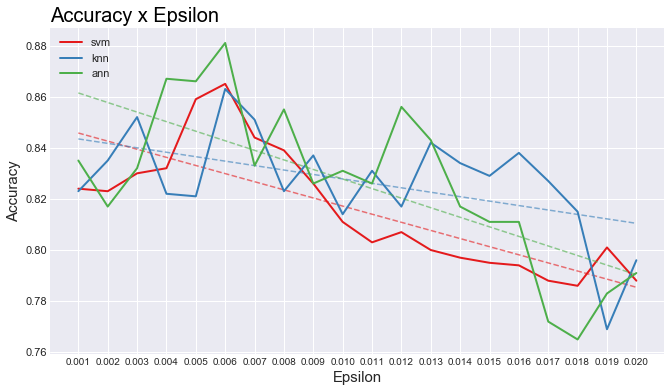

In [174]:
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.figure(figsize=(11, 6))
plt.xticks(poly_models, fontsize=10) 

num = 0
plt.plot(poly_models, svm_avg_accs, marker='', color=palette(num), linewidth=2, alpha=1, label='svm')
z = np.polyfit(poly_models, svm_avg_accs, 1)
p = np.poly1d(z)
plt.plot(poly_models, p(poly_models), 'r--', color=palette(num), alpha=0.6)

num = 1
plt.plot(poly_models, knn_avg_accs, marker='', color=palette(num), linewidth=2, alpha=1, label='knn')
z = np.polyfit(poly_models, knn_avg_accs, 1)
p = np.poly1d(z)
plt.plot(poly_models, p(poly_models), 'r--', color=palette(num), alpha=0.6)

num = 2
plt.plot(poly_models, ann_avg_accs, marker='', color=palette(num), linewidth=2, alpha=1, label='ann')
z = np.polyfit(poly_models, ann_avg_accs, 1)
p = np.poly1d(z)
plt.plot(poly_models, p(poly_models), 'r--', color=palette(num), alpha=0.6)

# Add legend
plt.legend(loc=2, ncol=1)

plt.title('Accuracy x Epsilon', loc='left', fontsize=20, fontweight=0, color='black')
plt.xlabel("Epsilon", fontsize=15)
plt.ylabel("Accuracy", fontsize=15)


plt.savefig('acc_100h_tline', dpi=150)

plt.show()

In [100]:
fst = DataFrame(svm_folds_accs)
snd = DataFrame(knn_folds_accs)
trd = DataFrame(ann_folds_accs)

df = concat([fst, snd, trd], axis=1, ignore_index=True)
df = df.T
df.columns = ['accuracy', 'poly_mod', 'classifier']

df

,accuracy,poly_mod,classifier
0,0.8,0.001,svm
1,0.9,0.001,svm
2,0.8,0.001,svm
3,0.8,0.001,svm
4,0.8,0.001,svm
5,0.8,0.001,svm
6,0.9,0.001,svm
7,0.8,0.001,svm
8,0.8,0.001,svm
9,0.9,0.001,svm


[0.001 0.002 0.003 0.004 0.005 0.006 0.007 0.008 0.009 0.01  0.011 0.012
 0.013 0.014 0.015 0.016 0.017 0.018 0.019 0.02 ]


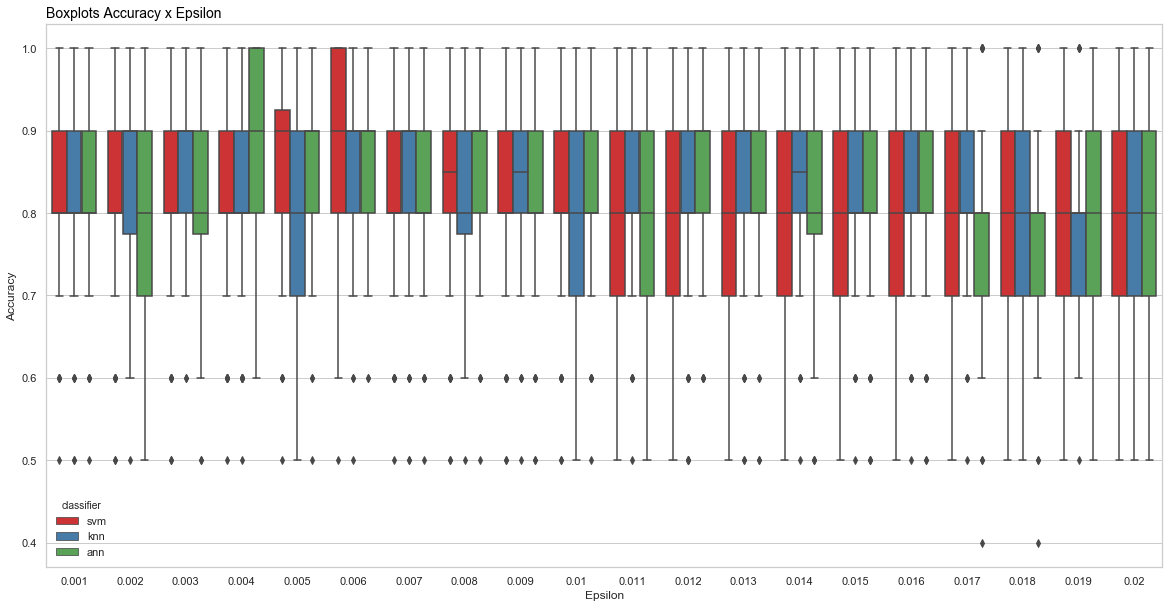

In [130]:
df['poly_mod'] = df['poly_mod'].astype(float)
df['accuracy'] = df['accuracy'].astype(float)

plt.figure(figsize=(20,10))
plt.xticks(poly_models) 

sbn.set(style='whitegrid')
boxplot = sbn.boxplot(x='poly_mod', y='accuracy', hue='classifier', palette='Set1', data=df)

plt.title('Boxplots Accuracy x Epsilon', loc='left', fontsize=14, fontweight=0, color='black')
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")

plt.savefig('BoxplotAccuracyEpsilon', dpi=300)
print(poly_models)

In [96]:
ttest = stats.ttest_ind(svm_accs_poly[0], svm_accs_poly[1])
ttest[1]

0.9500809452912673

In [97]:
svm_macc = np.zeros((poly_models.shape[0], poly_models.shape[0]))
knn_macc = np.zeros((poly_models.shape[0], poly_models.shape[0]))
ann_macc = np.zeros((poly_models.shape[0], poly_models.shape[0]))

svm_mauc = np.zeros((poly_models.shape[0], poly_models.shape[0]))
knn_mauc = np.zeros((poly_models.shape[0], poly_models.shape[0]))
ann_mauc = np.zeros((poly_models.shape[0], poly_models.shape[0]))

for t in tech:
    if t == 'svm':
        for i in range(poly_models.shape[0]):
            for j in range(poly_models.shape[0]):
                svm_macc[i, j] = stats.ttest_ind(svm_accs_poly[i], svm_accs_poly[j])[1]
                svm_mauc[i, j] = stats.ttest_ind(svm_auc_poly[i], svm_auc_poly[j])[1]
                
        svm_df = DataFrame(svm_macc, index=np.round(poly_models, 4), columns=np.round(poly_models, 4))
        writer = ExcelWriter('acc_p_value_matrix_'+ t +'.xlsx', engine='xlsxwriter')
        svm_df.to_excel(writer, sheet_name='Sheet1')
        writer.save()
        
        svm_df = DataFrame(svm_mauc, index=np.round(poly_models, 4), columns=np.round(poly_models, 4))
        writer = ExcelWriter('auc_p_value_matrix_'+ t +'.xlsx', engine='xlsxwriter')
        svm_df.to_excel(writer, sheet_name='Sheet1')
        writer.save()
        
        
    elif t == 'knn':
        for i in range(poly_models.shape[0]):
            for j in range(poly_models.shape[0]):
                knn_macc[i, j] = stats.ttest_ind(knn_accs_poly[i], knn_accs_poly[j])[1]
                knn_mauc[i, j] = stats.ttest_ind(knn_auc_poly[i], knn_auc_poly[j])[1]
                
        knn_df = DataFrame(knn_macc, index=np.round(poly_models, 4), columns=np.round(poly_models, 4))
        writer = ExcelWriter('acc_p_value_matrix_'+ t +'.xlsx', engine='xlsxwriter')
        knn_df.to_excel(writer, sheet_name='Sheet1')
        writer.save()
        
        knn_df = DataFrame(knn_mauc, index=np.round(poly_models, 4), columns=np.round(poly_models, 4))
        writer = ExcelWriter('auc_p_value_matrix_'+ t +'.xlsx', engine='xlsxwriter')
        knn_df.to_excel(writer, sheet_name='Sheet1')
        writer.save()
        
        
    elif t == 'ann':
        for i in range(poly_models.shape[0]):
            for j in range(poly_models.shape[0]):
                ann_macc[i, j] = stats.ttest_ind(ann_accs_poly[i], ann_accs_poly[j])[1]
                ann_mauc[i, j] = stats.ttest_ind(ann_auc_poly[i], ann_auc_poly[j])[1]
                
        ann_df = DataFrame(ann_macc, index=np.round(poly_models, 4), columns=np.round(poly_models, 4))
        writer = ExcelWriter('acc_p_value_matrix_'+ t +'.xlsx', engine='xlsxwriter')
        ann_df.to_excel(writer, sheet_name='Sheet1')
        writer.save()
        
        ann_df = DataFrame(ann_mauc, index=np.round(poly_models, 4), columns=np.round(poly_models, 4))
        writer = ExcelWriter('auc_p_value_matrix_'+ t +'.xlsx', engine='xlsxwriter')
        ann_df.to_excel(writer, sheet_name='Sheet1')
        writer.save()
        
    else:
        print('qq ta conteceno? nem deveria chegar aqui')
        
df = DataFrame(svm_macc, index=np.round(poly_models, 4), columns=np.round(poly_models, 4))
ann_df

,0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01,0.011,0.012,0.013,0.014,0.015,0.016,0.017,0.018,0.019,0.02
0.001,1.000000,0.211055,0.588871,0.157428,1.390484e-02,1.768647e-03,0.855311,0.131102,0.802952,0.382496,0.813635,5.936574e-02,0.291095,0.507534,0.702333,0.363669,4.125177e-03,1.364780e-03,1.998295e-02,5.255951e-02
0.002,0.211055,1.000000,0.548873,0.008044,1.514318e-04,8.481403e-06,0.139587,0.004904,0.111461,0.026172,0.295737,1.299082e-03,0.018899,0.533020,0.348891,0.693857,8.970404e-02,4.538686e-02,2.800008e-01,5.332107e-01
0.003,0.588871,0.548873,1.000000,0.067806,5.407596e-03,7.321676e-04,0.470616,0.054222,0.425288,0.173566,0.735939,2.339042e-02,0.130485,0.961393,0.826532,0.791875,3.376788e-02,1.620746e-02,1.142788e-01,2.355540e-01
0.004,0.157428,0.008044,0.067806,1.000000,3.533071e-01,1.117966e-01,0.199631,0.984815,0.204650,0.508000,0.092839,7.194281e-01,0.677199,0.035064,0.061978,0.017899,3.099062e-05,5.966598e-06,2.076133e-04,6.749697e-04
0.005,0.013905,0.000151,0.005408,0.353307,1.000000e+00,4.664895e-01,0.017963,0.333095,0.016268,0.079663,0.005427,5.336086e-01,0.153333,0.001168,0.002489,0.000390,1.050392e-07,8.922601e-09,8.349977e-07,2.796336e-06
0.006,0.001769,0.000008,0.000732,0.111797,4.664895e-01,1.000000e+00,0.002191,0.093926,0.001738,0.012791,0.000527,1.770788e-01,0.033554,0.000083,0.000187,0.000022,3.010349e-09,1.745232e-10,2.305994e-08,7.009742e-08
0.007,0.855311,0.139587,0.470616,0.199631,1.796291e-02,2.191160e-03,1.000000,0.168295,0.949707,0.476740,0.666060,7.715233e-02,0.364470,0.381430,0.555083,0.256964,1.744192e-03,4.899722e-04,9.542171e-03,2.722674e-02
0.008,0.131102,0.004904,0.054222,0.984815,3.330950e-01,9.392650e-02,0.168295,1.000000,0.170858,0.468009,0.072449,7.176752e-01,0.644937,0.024541,0.045493,0.011488,1.153152e-05,1.755458e-06,8.446560e-05,2.871297e-04
0.009,0.802952,0.111461,0.425288,0.204650,1.626823e-02,1.738275e-03,0.949707,0.170858,1.000000,0.499030,0.609833,7.552275e-02,0.379180,0.331287,0.497395,0.214229,1.004822e-03,2.465466e-04,5.996366e-03,1.809747e-02
0.010,0.382496,0.026172,0.173566,0.508000,7.966318e-02,1.279088e-02,0.476740,0.468009,0.499030,1.000000,0.248645,2.622767e-01,0.811101,0.105097,0.178496,0.057109,1.023647e-04,1.852577e-05,7.116207e-04,2.363420e-03
